In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import librosa
from librosa.core import audio
import librosa.display
import IPython.display as  ipd
import warnings
warnings.filterwarnings('ignore')
import os

In [2]:
dir = "/Users/tainguyen/Library/CloudStorage/OneDrive-MichiganStateUniversity/Phuoc Tai Mastermind/Personal/Tai/Song_Data/fma_metadata"

## General Informations about the song

In [33]:
tracks = pd.read_csv(dir+"/tracks.csv",header=[0,1])
tracks.columns = tracks.columns.map('_'.join)
tracks.rename(columns={ tracks.columns[0]: "track_id" }, inplace = True)
tracks = tracks.iloc[1: , :]
print("shape of the tracks dataframe: ",str(tracks.shape))
tracks.head()

shape of the tracks dataframe:  (106574, 53)


,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title
1,2,0.0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4.0,1.0,<p></p>,6073.0,NaN,...,NaN,4656.0,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293.0,NaN,3.0,NaN,[],Food
2,3,0.0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4.0,1.0,<p></p>,6073.0,NaN,...,NaN,1470.0,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514.0,NaN,4.0,NaN,[],Electric Ave
3,5,0.0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4.0,1.0,<p></p>,6073.0,NaN,...,NaN,1933.0,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151.0,NaN,6.0,NaN,[],This World
4,10,0.0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4.0,6.0,NaN,47632.0,NaN,...,NaN,54881.0,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135.0,NaN,1.0,NaN,[],Freeway
5,20,0.0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2.0,4.0,"<p> ""spiritual songs"" from Nicky Cook</p>",2710.0,NaN,...,NaN,978.0,en,Attribution-NonCommercial-NoDerivatives (aka M...,361.0,NaN,3.0,NaN,[],Spiritual Level


In [32]:
tracks.columns

Index(['track_id', 'album_comments', 'album_date_created',
       'album_date_released', 'album_engineer', 'album_favorites', 'album_id',
       'album_information', 'album_listens', 'album_producer', 'album_tags',
       'album_title', 'album_tracks', 'album_type', 'artist_active_year_begin',
       'artist_active_year_end', 'artist_associated_labels', 'artist_bio',
       'artist_comments', 'artist_date_created', 'artist_favorites',
       'artist_id', 'artist_latitude', 'artist_location', 'artist_longitude',
       'artist_members', 'artist_name', 'artist_related_projects',
       'artist_tags', 'artist_website', 'artist_wikipedia_page', 'set_split',
       'set_subset', 'track_bit_rate', 'track_comments', 'track_composer',
       'track_date_created', 'track_date_recorded', 'track_duration',
       'track_favorites', 'track_genre_top', 'track_genres',
       'track_genres_all', 'track_information', 'track_interest',
       'track_language_code', 'track_license', 'track_listens',
  

There are total of 106574 songs with information about the album that song is in, the artist, and general information about the song like the release date and others. For the purpose of this project, I will only get the track_duration, track_genres, and track_title from this dataset.

In [80]:
tracks_features_of_interest = tracks[['track_id', 'track_duration', 'track_genre_top', 'track_title']]
tracks_features_of_interest.head()

,track_id,track_duration,track_genre_top,track_title
1,2,168.0,Hip-Hop,Food
2,3,237.0,Hip-Hop,Electric Ave
3,5,206.0,Hip-Hop,This World
4,10,161.0,Pop,Freeway
5,20,311.0,NaN,Spiritual Level


## Features from Librosa

In [45]:
features = pd.read_csv(dir+"/features.csv", header=[0,1,2])
features.columns = features.columns.map('_'.join)
features.rename(columns={ features.columns[0]: "track_id" }, inplace = True)
features = features.iloc[1: , :]
print("shape of the tracks dataframe: ",str(features.shape))
features.head()

shape of the tracks dataframe:  (106574, 519)


,track_id,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
1,2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
2,3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
3,5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
4,10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
5,20,-0.193837,-0.198527,0.201546,0.258556,0.775204,0.084794,-0.289294,-0.816410,0.043851,...,0.095003,0.022492,0.021355,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993


In [44]:
features.columns

Index(['feature_statistics_number', 'chroma_cens_kurtosis_01',
       'chroma_cens_kurtosis_02', 'chroma_cens_kurtosis_03',
       'chroma_cens_kurtosis_04', 'chroma_cens_kurtosis_05',
       'chroma_cens_kurtosis_06', 'chroma_cens_kurtosis_07',
       'chroma_cens_kurtosis_08', 'chroma_cens_kurtosis_09',
       ...
       'tonnetz_std_04', 'tonnetz_std_05', 'tonnetz_std_06', 'zcr_kurtosis_01',
       'zcr_max_01', 'zcr_mean_01', 'zcr_median_01', 'zcr_min_01',
       'zcr_skew_01', 'zcr_std_01'],
      dtype='object', length=519)

## Features from Echonest (Spotify)

In [74]:
echonest = pd.read_csv(dir+"/echonest.csv", header=[0,1,2])
echonest.columns = echonest.columns.map('_'.join)
echonest.rename(columns={ echonest.columns[0]: "track_id" }, inplace = True)
echonest = echonest.iloc[1: , :]
#echonest.columns = [col.replace('_', ' ') for col in echonest.columns]
print("shape of the echonest dataframe: ",str(echonest.shape))
echonest.head()

shape of the echonest dataframe:  (13129, 250)


,track_id,echonest_audio_features_acousticness,echonest_audio_features_danceability,echonest_audio_features_energy,echonest_audio_features_instrumentalness,echonest_audio_features_liveness,echonest_audio_features_speechiness,echonest_audio_features_tempo,echonest_audio_features_valence,echonest_metadata_album_date,...,echonest_temporal_features_214,echonest_temporal_features_215,echonest_temporal_features_216,echonest_temporal_features_217,echonest_temporal_features_218,echonest_temporal_features_219,echonest_temporal_features_220,echonest_temporal_features_221,echonest_temporal_features_222,echonest_temporal_features_223
1,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,NaN,...,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.67696,3.61288,13.316690,262.929749
2,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,NaN,...,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.08277,6.01864,16.673548,325.581085
3,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,NaN,...,-2.288358,11.527109,0.256821,0.237820,0.060122,0.06014,5.92649,5.86635,16.013849,356.755737
4,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,2008-03-11,...,-3.662988,21.508228,0.283352,0.267070,0.125704,0.08082,8.41401,8.33319,21.317064,483.403809
5,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,NaN,...,-1.452696,2.356398,0.234686,0.199550,0.149332,0.06440,11.26707,11.20267,26.454180,751.147705


In [77]:
echonest.columns

Index(['track_id', 'echonest_audio_features_acousticness',
       'echonest_audio_features_danceability',
       'echonest_audio_features_energy',
       'echonest_audio_features_instrumentalness',
       'echonest_audio_features_liveness',
       'echonest_audio_features_speechiness', 'echonest_audio_features_tempo',
       'echonest_audio_features_valence', 'echonest_metadata_album_date',
       ...
       'echonest_temporal_features_214', 'echonest_temporal_features_215',
       'echonest_temporal_features_216', 'echonest_temporal_features_217',
       'echonest_temporal_features_218', 'echonest_temporal_features_219',
       'echonest_temporal_features_220', 'echonest_temporal_features_221',
       'echonest_temporal_features_222', 'echonest_temporal_features_223'],
      dtype='object', length=250)

In [78]:
features_of_interest = ('track_id','acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence')
echonest_features_of_interest = echonest.loc[:, echonest.columns.str.endswith(features_of_interest)]
echonest_features_of_interest.head()

,track_id,echonest_audio_features_acousticness,echonest_audio_features_danceability,echonest_audio_features_energy,echonest_audio_features_instrumentalness,echonest_audio_features_liveness,echonest_audio_features_speechiness,echonest_audio_features_tempo,echonest_audio_features_valence
1,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
2,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
3,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
4,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
5,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072


## Combine All Features

In [84]:
from functools import reduce

# compile the list of dataframes you want to merge
data_frames = [tracks_features_of_interest, echonest_features_of_interest, features]
data = reduce(lambda  left,right: pd.merge(left,right,on=['track_id'],
                                            how='inner'), data_frames)
print("The shape of the combined data: ",str(data.shape))

The shape of the combined data:  (7307, 530)


In [93]:
data = data.dropna(subset=['track_genre_top'])
print("The shape of the data after dropping empty values in genre column: ", str(data.shape))

The shape of the data after dropping empty values in genre column:  (4743, 530)


<AxesSubplot:>

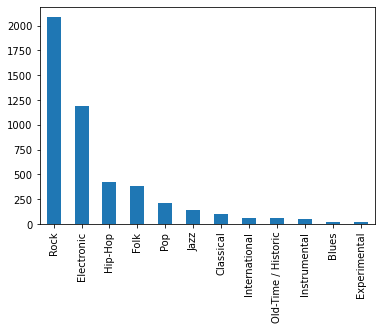

In [94]:
data['track_genre_top'].value_counts().plot.bar()

There is a problem of imbalance among the genre, where Rocks have the most tracks with the features of interest, and Blues have the least tracks.